In [18]:
%matplotlib inline
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
import random
import json
import requests

from config import api_key


# Extract AADT data from Caltrans and reference the CSV file from 2014 to 2017
csv_path = "2017_peak_hours_report_kdfactor.csv"

# Read the CSV into a Pandas DataFrame
aadt_df = pd.read_csv(csv_path)

# Print the first five rows of data to the screen
aadt_df.head()

,Year,District,Route,County,Postmile,Descriptn,Back_pk_h,Back_pk_m,Back_AADT,Ahead_pk_h,Ahead_pk_m,Ahead_AADT,Lat_S_or_W,Lon_S_or_W,Lat_N_or_E,Lon_N_or_E
0,2017,12,1,ORA,R0.129,"DANA POINT, JCT. RTE. 5",0,0,0,3800,41000,37750,33.467008,-117.669809,33.467078,-117.669952
1,2017,12,1,ORA,R0.78,"DANA POINT, DOHENY PARK ROAD",3800,41000,37750,3900,42000,38800,33.464080,-117.678915,33.464173,-117.678870
2,2017,12,1,ORA,R1.077,BREAK IN ROUTE,0,0,0,0,0,0,33.464159,-117.683985,33.464251,-117.683978
3,2017,12,1,ORA,8.43,"LAGUNA BEACH, MOUNTAIN ROAD",2900,39500,36800,2900,39500,36800,33.531702,-117.774805,33.531709,-117.774814
4,2017,12,1,ORA,9.418,"LAGUNA BEACH, JCT. RTE. 133 NORTH",3050,41000,38500,3450,41000,38500,33.542738,-117.785319,33.542738,-117.785319


In [19]:
# Extract Traffic Data from Uber and Lyft and reference the CSV file desired
uber_lyft = "SF_TRAFFIC_2016.csv"

# Read the CSV into a Pandas DataFrame
uber_lyft_df = pd.read_csv(uber_lyft)

# Print the first five rows of data to the screen
uber_lyft_df.head()

,Unnamed: 0,ID,ModifiedTMC,TOD,YEAR,CHAMP_LINK_COUNT,PHF,ALPHA,BETA,FT2,...,FFS,INRIX_SPEED,SPEED_20TH,FF_TIME,INRIX_TIME,INRIX_VOL,CHAMP_PCE,CHAMP_VOL,TNC_VOL,TNC_PUDO
0,0,105&10491_AM,105&10491,AM,2016,2,0.348,0.60,3.5,2,...,28.467037,18.088510,10.483549,0.358309,0.563894,7660.134930,6320.848807,5793.641565,382.930621,9.324706
1,1,105&14211_AM,105&14211,AM,2016,6,0.348,0.60,8.5,4,...,25.215407,16.902508,14.949591,1.427699,2.129861,1342.742061,492.161158,459.129478,35.819280,0.315167
2,11,105+04869_AM,105+04869,AM,2016,8,0.348,0.83,8.5,1,...,67.730000,52.759624,49.480000,0.951248,1.221161,9359.350223,7463.839934,6847.118463,317.581145,0.244180
3,13,105+04873_AM,105+04873,AM,2016,1,0.348,0.60,8.5,4,...,45.930000,20.649362,7.180000,0.222077,0.493962,937.520667,229.839170,180.880750,87.934850,3.110000
4,15,105+05618_AM,105+05618,AM,2016,4,0.348,0.83,5.5,1,...,62.480000,37.604309,14.976000,0.525192,0.872613,11800.524230,7594.111413,7258.430157,51.922407,1.394222


In [20]:
print(f"AADT_data shape ={aadt_df.shape}")
print(f"UBER_LYFT_data shape ={uber_lyft_df.shape}")

AADT_data shape =(28093, 16)
UBER_LYFT_data shape =(6694, 23)


In [21]:
# Transform and Check to see if there are any rows with missing data
aadt_df.dropna(how='any')  # clean up null values
aadt_df.count()

Year          28093
District      28093
Route         28093
County        28093
Postmile      28093
Descriptn     28093
Back_pk_h     28093
Back_pk_m     28093
Back_AADT     28093
Ahead_pk_h    28093
Ahead_pk_m    28093
Ahead_AADT    28093
Lat_S_or_W    28093
Lon_S_or_W    28093
Lat_N_or_E    28093
Lon_N_or_E    28093
dtype: int64

In [22]:
# Transform and Check to see if there are any rows with missing data
uber_lyft_df.dropna(how='any')  # clean up null values
uber_lyft_df.count()

Unnamed: 0          6694
ID                  6694
ModifiedTMC         6694
TOD                 6694
YEAR                6694
CHAMP_LINK_COUNT    6694
PHF                 6694
ALPHA               6694
BETA                6694
FT2                 6694
LANES               6694
DISTANCE            6694
CAPACITY            6694
FFS                 6694
INRIX_SPEED         6694
SPEED_20TH          6694
FF_TIME             6694
INRIX_TIME          6694
INRIX_VOL           6694
CHAMP_PCE           6694
CHAMP_VOL           6694
TNC_VOL             6694
TNC_PUDO            6694
dtype: int64

In [23]:
# Transform CA traffic data into dataframe 
columns = [
"Year", 
"District",   # Caltrans has twelve transportation districts statewide. This abbreviation identifies the district in which the count station is located. 
"Route",   # The state highway route number. 
"County",  # County abbreviation used by Caltrans
"Postmile", # The Post Mile is the mileage measured from the county line, or from the beginning of a route. Each postmile along a route in a county is a unique location on the state highway system. 
"Descriptn", # description for segment
"Back_AADT", # Annual Average Daily Traffic (24hr - reverse commute)
"Ahead_AADT", # Annual Average Daily Traffic (24hr - peak commute)
"Lat_S_or_W", # NAD83 latitude for end node 
"Lon_S_or_W",  # NAD83 longitude for end node
"Lat_N_or_E",  # NAD83 longitude for start node
"Lon_N_or_E"  # NAD83 longitude for start node
]

In [24]:
# Create a group based on the routes and mile post in California
aadt_group = aadt_df.groupby(['County', 'Route','Postmile','Year'])

# look at count per location
print(f"aadt_group.count={aadt_group.count()}")

# Count how many times each location appears in our group

aadt_group.count=                            District  Descriptn  Back_pk_h  Back_pk_m  \
County Route Postmile Year                                              
ALA    112   0.602    2014         1          1          1          1   
                      2015         1          1          1          1   
                      2016         1          1          1          1   
                      2017         1          1          1          1   
             1.507    2014         1          1          1          1   
                      2015         1          1          1          1   
                      2016         1          1          1          1   
                      2017         1          1          1          1   
             1.782    2014         1          1          1          1   
                      2015         1          1          1          1   
                      2016         1          1          1          1   
                      2017        

In [25]:
uber_lyft_df.count()

Unnamed: 0          6694
ID                  6694
ModifiedTMC         6694
TOD                 6694
YEAR                6694
CHAMP_LINK_COUNT    6694
PHF                 6694
ALPHA               6694
BETA                6694
FT2                 6694
LANES               6694
DISTANCE            6694
CAPACITY            6694
FFS                 6694
INRIX_SPEED         6694
SPEED_20TH          6694
FF_TIME             6694
INRIX_TIME          6694
INRIX_VOL           6694
CHAMP_PCE           6694
CHAMP_VOL           6694
TNC_VOL             6694
TNC_PUDO            6694
dtype: int64

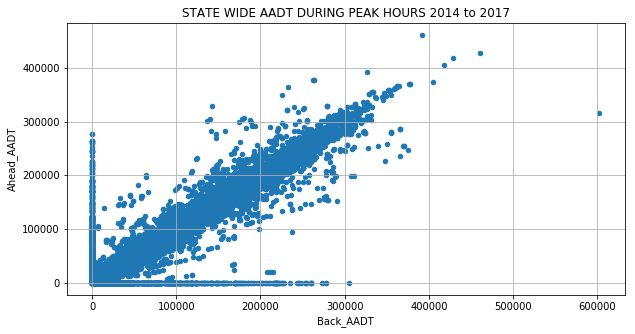

In [26]:
# Create a scatter plot which compares PM PHV  to AM PHV for all highways
aadt_df.plot(kind="scatter", x="Back_AADT", y="Ahead_AADT", grid=True, figsize=(10,5),
              title="STATE WIDE AADT DURING PEAK HOURS 2014 to 2017")
plt.show()
# 28000 records of AADT with route and mile 
# Plot indicates head and back commute have same AADT.  

In [27]:
#create summary 
County_sum = (aadt_df.groupby("County")["Ahead_AADT"].count())
AM_max = (aadt_df.groupby("County")["Ahead_AADT"].max())
AM_avg = (aadt_df.groupby("County")["Ahead_AADT"].mean())
AM_min = (aadt_df.groupby("County")["Ahead_AADT"].min())
ca_df = pd.DataFrame({'AM max AADT': AM_max, 'AM avg AADT': AM_avg, 'AM min AADT': AM_min })
ca_df.head()

,AM max AADT,AM avg AADT,AM min AADT
County,,,
ALA,293000,81506.010363,0
ALP,3550,1325.921053,0
AMA,20900,6160.638298,0
BUT,88000,15321.051345,0
CAL,15900,4945.850000,0


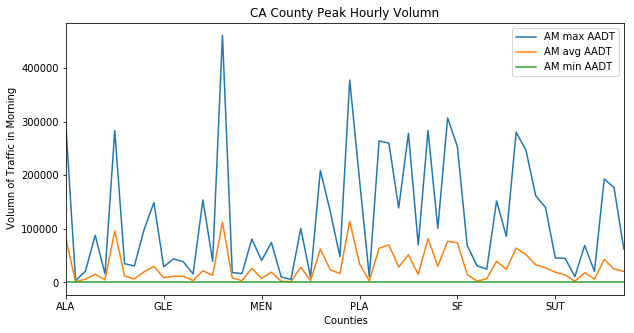

<Figure size 432x288 with 0 Axes>

In [28]:
# Set x axis and tick locations
x_axis = np.arange(len(aadt_df))
tick_locations = [value for value in x_axis]

# Plot Data 
ca_df.plot(kind="line", figsize=(10,5))

# Set a title for the chart
plt.title("CA County Peak Hourly Volumn")
plt.xlabel(" Counties")
plt.ylabel(" Volumn of Traffic in Morning")

#Add the legend.
legend = plt.legend(loc = "best")
legend.legendHandles[0]._sizes = [30]
legend.legendHandles[1]._sizes = [30]
legend.legendHandles[2]._sizes = [30]

plt.show()
plt.tight_layout()

In [29]:
# Collect a list of traffic DATA FOR UBER AND LYFT
columns = [
"ID",
"ModifiedTMC",
"TOD",
"YEAR",
"CHAMP_LINK_COUNT",
"PHF",
"ALPHA",
"BETA",
"FT2",
"LANES",
"DISTANCE",
"CAPACITY",
"FFS",
"INRIX_SPEED",
"SPEED_20TH",
"FF_TIME",
"INRIX_TIME",
"INRIX_VOL",
"CHAMP_PCE",
"CHAMP_VOL",
"TNC_VOL"
"TNC_PUDO"   
]

# ID - a unique ID, which is a combination of the next two fields
# ModifiedTMC	- ID for the spatial unit of analysis, a directional section of roadway
# TOD	- Time-of-day: AM=6-9 AM, MD=9 AM-3:30 PM, PM=3:30-6:30 PM, EV=6:30 PM-3:00 AM, EA=3-6 AM
# YEAR - The year, either 2010 or 2016
# CHAMP_LINK_COUNT - The number of SF-CHAMP links that aggregate to this ModifiedTMC
# PHF	- Peak Hour Factor, the share of the total period volume that occurs in the highest 1-hour period
# ALPHA - alpha term for use in VDF(volume-delay functions, the probability of Type I error in any hypothesis test–incorrectly rejecting the null hypothesis.)
# BETA - beta term for use in VDF (volume-delay functions, the probability of Type II error in any hypothesis test–incorrectly failing to reject the null hypothesis)
# AT - Area Type: 0=Regional Core, 1=Central Business Distritc, 2=Urban Business, 3=Urban
# FT2 - Facility Type: 1-Freeway, Expressway or Ramp, 2=Major Arterial, 3=Minor Arterial, 4=Local or Collector
# LANES - Number of lanes (can be non-integer due to averaging across SF-CHAMP links)
# DISTANCE - distance in miles
# CAPACITY - capacity in vehicles for the period as a whole
# FFS	- free flow speed
# INRIX_SPEED	- average speed, as measured by INRIX data
# SPEED_20TH - 20th percentile speed, as measured by INRIX data
# FF_TIME	- free flow travel time
# INRIX_TIME - average travel time, as measured by INRIX data
# INRIX_VOL - implied volume
# CHAMP_PCE - SF-CHAMP passenger car equivalents (PCEs)
# CHAMP_VOL - SF-CHAMP volume (vehicles)
# TNC_VOL	- TNC volume(transportation network companies,uber, lyft)
# TNC_PUDO - TNC pick-ups and drop-offs

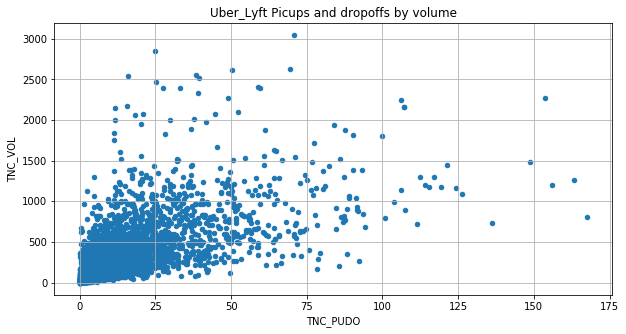

In [30]:
uber_lyft_df.plot(kind="scatter", x="TNC_PUDO", y="TNC_VOL", grid=True, figsize=(10,5),
              title="Uber_Lyft Picups and dropoffs by volume")
plt.show()

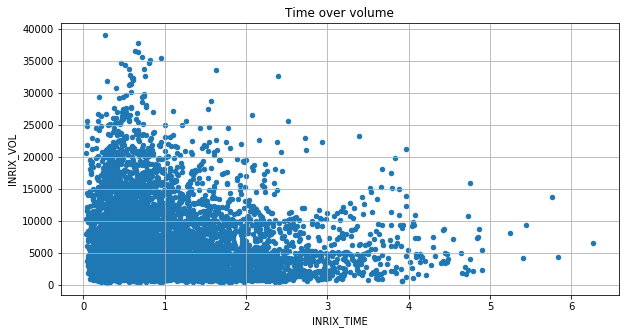

In [31]:
uber_lyft_df.plot(kind="scatter", x="INRIX_TIME", y="INRIX_VOL", grid=True, figsize=(10,5),
              title="Time over volume")
plt.show()

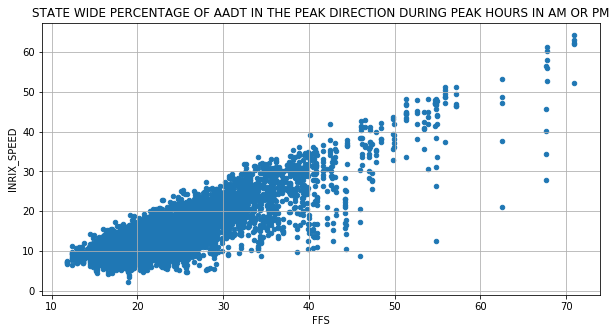

In [32]:
uber_lyft_df.plot(kind="scatter", x="FFS", y="INRIX_SPEED", grid=True, figsize=(10,5),
              title="STATE WIDE PERCENTAGE OF AADT IN THE PEAK DIRECTION DURING PEAK HOURS IN AM OR PM")
plt.show()

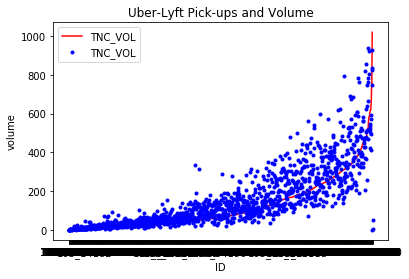

In [33]:
uber_lyft_tod_am = uber_lyft_df.loc[uber_lyft_df["TOD"] == "AM"]
uber_lyft_tod_am=uber_lyft_tod_am.sort_values("TNC_VOL")
uber_lyft_tod_pm = uber_lyft_df.loc[uber_lyft_df["TOD"] == "PM"]
uber_lyft_tod_pm = uber_lyft_tod_pm.sort_values("TNC_VOL")
plt.plot(uber_lyft_tod_am["ModifiedTMC"],uber_lyft_tod_am["TNC_VOL"],"r-")
plt.plot(uber_lyft_tod_pm["ModifiedTMC"],uber_lyft_tod_pm["TNC_VOL"],"b.")
# Plot Data
#traffic_sf_df.plot(kind=“line”, figsize=(10,5))
# Set a title for the chart
plt.title("Uber-Lyft Pick-ups and Volume")
plt.xlabel("ID")
plt.ylabel("volume")
#Add the legend.
legend = plt.legend(loc = "best")
#legend.legendHandles[0]._sizes = [30]
#legend.legendHandles[1]._sizes = [30]
#legend.legendHandles[2]._sizes = [30]
plt.show()

In [34]:
####################EXTRACT WEATHER DATA#####################################

In [35]:
# Save config informationfor open weather API
url = "http://api.openweathermap.org/data/2.5/weather?"
city1 = "San Francisco"

# Build query URL
query_url = url + "appid=" + api_key + "&q=" + city1

In [36]:
# Get weather data for SF from OPEN WEATHER API
weather_response = requests.get(query_url)
weather_json = weather_response.json()

#Get the temperature from the response
print(f"The weather API responded with: {weather_json}.")

The weather API responded with: {'coord': {'lon': -76.88, 'lat': 1.17}, 'weather': [{'id': 804, 'main': 'Clouds', 'description': 'overcast clouds', 'icon': '04n'}], 'base': 'stations', 'main': {'temp': 282.626, 'pressure': 1019.09, 'humidity': 89, 'temp_min': 282.626, 'temp_max': 282.626, 'sea_level': 1019.09, 'grnd_level': 759}, 'wind': {'speed': 0.82, 'deg': 240.429}, 'clouds': {'all': 100}, 'dt': 1565321360, 'sys': {'message': 0.0187, 'country': 'CO', 'sunrise': 1565262504, 'sunset': 1565306282}, 'timezone': -18000, 'id': 3669881, 'name': 'San Francisco', 'cod': 200}.


In [37]:
# Print the output of the JSON
print(json.dumps(weather_json, indent=4, sort_keys=True))

{
    "base": "stations",
    "clouds": {
        "all": 100
    },
    "cod": 200,
    "coord": {
        "lat": 1.17,
        "lon": -76.88
    },
    "dt": 1565321360,
    "id": 3669881,
    "main": {
        "grnd_level": 759,
        "humidity": 89,
        "pressure": 1019.09,
        "sea_level": 1019.09,
        "temp": 282.626,
        "temp_max": 282.626,
        "temp_min": 282.626
    },
    "name": "San Francisco",
    "sys": {
        "country": "CO",
        "message": 0.0187,
        "sunrise": 1565262504,
        "sunset": 1565306282
    },
    "timezone": -18000,
    "weather": [
        {
            "description": "overcast clouds",
            "icon": "04n",
            "id": 804,
            "main": "Clouds"
        }
    ],
    "wind": {
        "deg": 240.429,
        "speed": 0.82
    }
}


In [38]:
######################################EXTRACT SF LOCAL STREETS DATA##########################################

In [39]:
# Street_Pavement_Condition Legend
# Field Name Data / Type / Definition Notes (optional)
#   "CNN"           Number    CNN of street segment or intersection location
# "STREET"          Text / VarChar      Street name
# "PCI_Score"       Number    Paving Condition Index Score
# "From_Street"     Text      Cross street 1
# "To_Street"       Text      Cross street 2
# "PCI_Change_Date" Date      Date condition score last updated
# Street_Accepted_For_Maintenance     Yes/No      Street accepted for maintenance by Public Works
# "Functional_Class" Text
# The functional class of the street segment:
# Arterial, Collector or Residential.

In [40]:
# Column Name      Description                 Type
#   "CNN"   unique street centerline ID       Number
# "STREET"  street name                       Plain Text / VarChar
# "ST_TYPE" street type                       Plain Text
# "NHOOD"   neighborhood the street segment is in / Plain Text  
# "CNNTEXT" CNN as a text field              Plain Text              
# "shape"                                    Line-String

In [41]:
# Extract CSVs into DataFrames

In [42]:
# Extract Street_Pavement_Condition.csv into DataFrames (City Infrastructure)
SPC_file = "Street_Conditions_2017.csv"
Street_Condition_df = pd.read_csv(SPC_file)
Street_Condition_df.head(10)

,CNN,STREET,PCI_Score,From_Street,To_Street,PCI_Change_Date,Treatment_or_Survey,Street_Accepted_For_Maintenance,Functional_Class
0,8321000,Liberty St,100,Valencia St,Guerrero St,12/28/17,Treatment,Yes,Residential
1,33124000,HUMBOLDT ST,100,VERMONT ST,Intersection,12/27/17,Treatment,No,NaN
2,51760000,Bay Shore Blvd On Ramp: Hwy 101 S On Ramp \ Po...,100,HWY 101 S ON RAMP \ POTRERO AVE,Intersection,12/27/17,Treatment,No,NaN
3,13219000,Vermont St,100,22nd St,Humboldt St,12/27/17,Treatment,Yes,Residential
4,13220000,Vermont St,100,Humboldt St,23rd St,12/27/17,Treatment,Yes,Residential
5,8436000,Lombard St,100,Child St,Julius St,12/18/17,Treatment,Yes,Residential
6,11583000,Santa Paula Ave,100,Santa Monica Way,Terrace Walk \ Yerba Buena Ave,12/18/17,Treatment,Yes,Residential
7,13524002,Webster St,100,Rose St,Page St,12/18/17,Treatment,Yes,Arterial
8,11582000,Santa Paula Ave,100,Portola Dr,Santa Monica Way,12/18/17,Treatment,Yes,Residential
9,13524001,Webster St,100,Haight St,Rose St,12/18/17,Treatment,Yes,Arterial


In [43]:
# Extract Rush_Hour_Routes.csv into Dataframes
RH_file = "Rush_Hour_Routes.csv"
Rush_Hour_Routes_df = pd.read_csv(RH_file)
Rush_Hour_Routes_df.head(10)

,CNN,Street_name,ST_TYPE,NHOOD,CNNTEXT,shape
0,164000,03RD,ST,Financial District South,164000,LINESTRING (-122.40302819316682 37.78702441841...
1,171000,03RD,ST,Financial District South,171000,LINESTRING (-122.39794293881961 37.78299789708...
2,170000,03RD,ST,Financial District South,170000,LINESTRING (-122.39893033171637 37.78378493342...
3,174000,03RD,ST,Financial District South,174000,LINESTRING (-122.39637951941779 37.78175028392...
4,168000,03RD,ST,Financial District South,168000,LINESTRING (-122.40046848439732 37.78503028445...
5,175000,03RD,ST,Financial District South,175000,LINESTRING (-122.39584349887906 37.78132125731...
6,172000,03RD,ST,Financial District South,172000,LINESTRING (-122.39738553904088 37.78255359330...
7,173000,03RD,ST,Financial District South,173000,LINESTRING (-122.39684142722312 37.78211912139...
8,169000,03RD,ST,Financial District South,169000,LINESTRING (-122.3994598243438 37.784213640305...
9,166000,03RD,ST,Financial District South,166000,LINESTRING (-122.40202541968891 37.78624815175...


In [44]:
####################################  Transform Street_Condition_df DataFrame################################### 

In [45]:
# Create a filtered dataframe from specific columns
SPC_cols = ["STREET","CNN","Street_Accepted_For_Maintenance"]
SPC_transformed = Street_Condition_df[SPC_cols].copy()

# Rename the column headers
SPC_transformed = SPC_transformed.rename(columns={"STREET":"Street",
                                                  "CNN":"Cnn",
                                                  "Street_Accepted_For_Maintenance":"Street_Maintenance"})

# Clean the data by dropping duplicates and setting the index
SPC_transformed.drop_duplicates("Cnn", inplace=True)
SPC_transformed.set_index("Cnn", inplace=True)

SPC_transformed.head()

,Street,Street_Maintenance
Cnn,,
8321000,Liberty St,Yes
33124000,HUMBOLDT ST,No
51760000,Bay Shore Blvd On Ramp: Hwy 101 S On Ramp \ Po...,No
13219000,Vermont St,Yes
13220000,Vermont St,Yes


In [46]:
################################### Transform Rush_Hour_Routes_df Dataframe################################### 

In [47]:
# Create a filtered dataframe from specific columns
RH_Routes_cols = ["Street_name","CNN", "NHOOD"]
RH_Routes_transformed = Rush_Hour_Routes_df[RH_Routes_cols].copy()

# Rename the column headers
RH_Routes_transformed = RH_Routes_transformed.rename(columns={"Street_name":"Street",
                                               "CNN":"Cnn",
                                               "NHOOD":"Neighborhood"}) 
# Set Index
RH_Routes_transformed.set_index("Cnn", inplace=True)
RH_Routes_transformed.head()

,Street,Neighborhood
Cnn,,
164000,03RD,Financial District South
171000,03RD,Financial District South
170000,03RD,Financial District South
174000,03RD,Financial District South
168000,03RD,Financial District South


In [48]:
# Create database , table schema , queries via PostgresSQL / Create Database connection 

In [49]:
connection_string = "postgres:Logan215@localhost:5432/Traffic_db"
engine = create_engine(f'postgresql://{connection_string}')

In [50]:
# Confirm tables (Street_Condition) & (Rush_Hour)
engine.table_names()

['Street_Condition',
 'Rush_Hour_Routes',
 'Street_Condition1',
 'Rush_Hour_Routes1',
 'uber_lyft_df',
 'aadt',
 'AADT']

In [51]:
# Load DataFrames into PostgresSQL database

In [52]:
SPC_transformed.to_sql(name='Street_Condition', con=engine, if_exists='append', index=True)

In [53]:
RH_Routes_transformed.to_sql(name='Rush_Hour_Routes', con=engine, if_exists='append', index=True)

In [54]:
aadt_df.to_sql(name='AADT', con=engine, if_exists='append', index=True)